The goal of this notebook is to calculate the Suspiciousness and Bayesian Model Dimensionality from a ${\tt CosmoSIS}$ run using the ${\tt anesthetic}$ package. 

${\tt anesthetic}$ is a publicly available code that can be used to plot and postprocess MCMC and Nested Sampling runs. It is programmed to read the output from ${\tt MultiNest}$ or ${\tt PolyChord}$, and can be used to calculate summary statistics from them. While in principle ${\tt CosmoSIS}$ produces similar outputs, the format in which these are produced is not the same. While in the future I would like to push an ${\tt anesthetic}$ update, this code can be used as a placeholder, in particular with the DES Y3 results in mind

The thing that ${\tt CosmoSIS}$ output is missing and ${\tt anesthetic}$ looks for is the paramnames file. This file provides ${\tt anesthetic}$ with names and LaTeX symbols for each parameter. In the future, I will do this in a better way, for now I recommend that you copy one of the files in this repository and adapt it to your case. I have added three files:

- DES.paramnames
- Planck.paramnames
- DES_Planck.paramnames

For the cases of DES alone, Planck alone or the combination of both respectively, all of them using $\mathrm{\Lambda CDM}$ with the usual nuisance parameters, and varying neutrino mass. You have to make sure to edit this files to the parameters in your problem.

You have to make sure that the name of the paramnames file matches the root of your chain. For example, if my chain is called d_3x2, and I have files such as d_3x2.txt and d_3x2_phys_live.txt, I need to have a file called d_3x2.paramnames

Also, please ignore the parameter named 'ww'. I am not sure what it is. 

# Single Chain

Let me put all of this to a test using Planck 2015 as an example. First we have to input ${\tt anesthetic}$. In particular, because this is a nested sampling chain, I will import the class NestedSamples.

In [15]:
%matplotlib inline
from anesthetic import NestedSamples
import matplotlib.pyplot as plt
import numpy as np

I now import my Planck chain

In [2]:
root_planck = 'chains/Planck'
samples_planck = NestedSamples(root=root_planck)

I can plot some of the parameters in my chain, to make sure that everything is correct. For that I must use the parameter names in the left column of the paramnames file

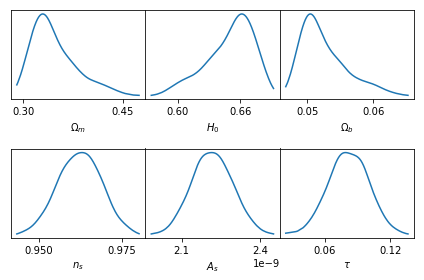

In [3]:
fig, axes = samples_planck.plot_1d(['omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'tau']);
fig.tight_layout()

Anesthetic can calculate the Bayesian Evidence (logZ), the Kullback-Leibler divergence (D) and the Bayesian model dimensionality. It does so by simulating the weights a number of times n (by default 200)

In [4]:
planck_output = samples_planck.ns_output()

To get the summary statistics with errorbars, we can take the mean and standard deviation of these quantities: 

In [5]:
print 'log Z =', planck_output.logZ.mean(), '+/-', planck_output.logZ.std()
print 'D_KL =', planck_output.D.mean(), '+/-', planck_output.D.std()
print 'BMD =', planck_output.d.mean(), '+/-', planck_output.d.std()

log Z = -5374.804269434046 +/- 0.30235545503483446
D_KL = 20.56377925882257 +/- 0.2954925279568592
BMD = 7.8378644544176135 +/- 0.3274429006916074


# Calculating Tension

To calculate the tension between this Planck chain and another one (in this case I will use a DES Y1 chain), you need two more chain, DES and DES+Planck. First, I will import them:

In [6]:
root_DES = 'chains/DES'
root_DES_planck = 'chains/DES_Planck'

samples_DES = NestedSamples(root=root_DES)
samples_DES_planck = NestedSamples(root=root_DES_planck)

Again, I can plot some of my parameters to check everything is as it should

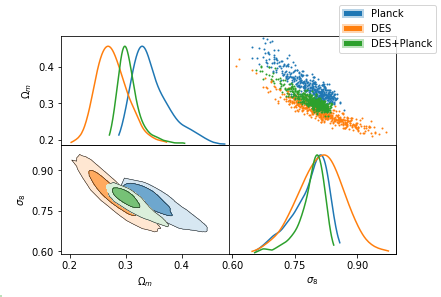

In [7]:
fig, axes = samples_planck.plot_2d(['omega_m', 'sigma_8'], label = 'Planck')
samples_DES.plot_2d(axes=axes, label = 'DES')
samples_DES_planck.plot_2d(axes=axes, label = 'DES+Planck')
handles, labels = axes['omega_m']['sigma_8'].get_legend_handles_labels()
leg = fig.legend(handles, labels)

Now we need to postprocess the DES and DES+Planck chains

In [8]:
DES_output = samples_DES.ns_output()
DES_planck_output = samples_DES_planck.ns_output()

Now, we can calculate the Bayes Ratio, and the Suspiciousness:

In [9]:
#Bayes Ratio
logR = DES_planck_output.logZ - planck_output.logZ - DES_output.logZ

#Information
logI = planck_output.D + DES_output.D - DES_planck_output.D

#Suspiciousness
logS = logR - logI

In [10]:
print 'log R =', logR.mean(), '+/-', logR.std()
print 'log I =', logI.mean(), '+/-', logI.std()
print 'log S =', logS.mean(), '+/-', logS.std()

log R = 1.1037173855615812 +/- 0.5740173802561576
log I = 4.350023033272891 +/- 0.5488760717015638
log S = -3.2463056477113104 +/- 0.2332989408831661


On its own, these numbers do not mean much, but we can convert them to a tension probability or number of sigma tension. To do so, we then need to calculate the Bayesian model dimensionality constrained by the combination of the data sets

In [11]:
#Bayesian Model Dimensionality
bmd = planck_output.d + DES_output.d - DES_planck_output.d

In [12]:
print 'd =', bmd.mean(), '+/-', bmd.std()

d = 1.9937475099234052 +/- 1.168697241849561


Now, the tension probability can be extracted under a Gaussian approximation, in which case $d - 2 \log S$ follows a $\chi^2_d$ distribution

In [22]:
from scipy.stats import chi2

#d-2*logS
d_2logS = bmd - 2*logS

#Tension probability
p = chi2.sf(d_2logS,bmd)

To extract the number of sigma, we can just use the function erfcinv from scipy.special, or just approximate it by $sqrt{d - 2 \log S}$. In both cases, we will run into problems if $d - 2 \log S$ is negative. Let me know if that happens. For now, I just remove the NAN cases

In [23]:
p = p[np.logical_not(np.isnan(p))]

In [24]:
print 'Tension Probability =', p.mean(), '+/-', p.std()
print 'Number of Sigma =', np.sqrt(d_2logS).mean(), '+/-', np.sqrt(d_2logS).std()

Tension Ptobability = 0.017113859613875546 +/- 0.01112133822861594
Number of Sigma = 2.9071575946747625 +/- 0.1865302256227643


Note that the tension probability is <0.03 but the number of sigma is <3. This might be surprising, but it is important to remember that the 68, 95, 99.7 rule only applies to one dimensional cases. But here, you have estimated d~2.

That is all you need to calculate the suspiciousness! If you have any questions, please ask me on pablo.lemos.18@ucl.ac.uk

Useful links: 

- ${\tt anesthetic}$: https://anesthetic.readthedocs.io/en/latest/
- ${\tt CosmoSIS}$: https://cosmosis.readthedocs.io/en/latest/
- ${\tt MultiNest}$: https://github.com/JohannesBuchner/MultiNest
- ${\tt PolyChord}$: https://github.com/PolyChord/PolyChordLite

In [ ]:
print 'BMD =', DES_output.d.mean(), '+/-', DES_output.d.std()
print 'BMD =', DES_planck_output.d.mean(), '+/-', DES_planck_output.d.std()